In [7]:
import gymnasium as gym

import numpy as np
from tqdm import tqdm

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

import torch.nn.functional as F
from torch.distributions import Normal
from torch.distributions import Beta

import matplotlib.pyplot as plt
from IPython.display import display, clear_output


In [8]:
class FeatureExtractor(nn.Module):
    def __init__(self, conv_layers_config):
        super(FeatureExtractor, self).__init__()
        self.layers = nn.ModuleList()

        # Input channels for the first convolutional layer
        in_channels = 4  # Adjusted for 4 stacked frames

        # Loop through the provided configuration
        for config in conv_layers_config:
            out_channels, kernel_size, stride = config
            conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
            bn_layer = nn.BatchNorm2d(out_channels)
            relu = nn.ReLU(inplace=True)
            self.layers.append(nn.Sequential(conv_layer, bn_layer, relu))  # Adding ReLU activation here
            in_channels = out_channels  # Update in_channels for the next layer

        # Initialize weights
        self.init_weights()

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        x = torch.flatten(x, start_dim=1)
        return x

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def calculate_conv_output_dim(self, conv_layers_config, input_size=(84, 84)):
        """
        Calculates the output dimension of the convolutional layers.
    
        Args:
            conv_layers_config: List of tuples with (out_channels, kernel_size, stride) for each conv layer.
            input_size: Tuple of (H, W) indicating the height and width of the input image.
    
        Returns:
            int: The total number of elements in the output after all conv layers.
        """
        height, width = input_size
        for _, kernel_size, stride in conv_layers_config:
            height = (height - kernel_size) // stride + 1
            width = (width - kernel_size) // stride + 1
    
        # Assuming the final conv layer's output is flattened
        return height * width * conv_layers_config[-1][0]  # Height * Width * Out_Channels of last conv layer
        

class ActorCriticNet(nn.Module):
    def __init__(self, action_dim, conv_layers_config, hidden_layers=[256, 128]):
        super(ActorCriticNet, self).__init__()
        self.feature_extractor = FeatureExtractor(conv_layers_config)
        input_dim = self.feature_extractor.calculate_conv_output_dim(conv_layers_config)
        print(f"input_dim: {input_dim}")
        # Shared layers
        self.shared_layers = nn.ModuleList()
        for output_dim in hidden_layers:
            self.shared_layers.append(nn.Linear(input_dim, output_dim))
            input_dim = output_dim
        
        # Actor heads
        self.alpha_head = nn.Linear(hidden_layers[-1], action_dim)
        self.beta_head = nn.Linear(hidden_layers[-1], action_dim)
        
        # Critic head
        self.value_head = nn.Linear(hidden_layers[-1], 1)
        
        self.init_weights()

    def forward(self, x):
        x = self.feature_extractor(x)
        for layer in self.shared_layers:
            x = F.relu(layer(x))
        alpha = F.softplus(self.alpha_head(x)) + 1
        beta = F.softplus(self.beta_head(x)) + 1
        value = self.value_head(x)
        return Beta(alpha, beta), value

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preprocess_image(state_image):
    # crop image to get rid of interface
    state_image = state_image[:84, 6:90]
    # get rid of color and normalize to [-1, 1]
    state_image = cv2.cvtColor(state_image, cv2.COLOR_RGB2GRAY) / 128. - 1
    return state_image


def preprocess_state(state):
    state_tensor = torch.from_numpy(state).float().to(device)
    state_tensor = state_tensor.unsqueeze(0)  # Add a channel dimension
    return state_tensor

In [10]:
class CarImageEnv(gym.Wrapper):
    def __init__(self, env, skip_frames=1, stack_frames=4, start_wait_steps=50, **kwargs):
        super(CarImageEnv, self).__init__(env, **kwargs)
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames
        self.start_wait_steps = start_wait_steps
        
    def reset(self):
        # reset the environment
        self.av_r = self.reward_memory()
        state, _ = self.env.reset()
        # do nothing for initial 50 steps until image zooms
        for i in range(self.start_wait_steps):
            next_state, reward, done, truncated, info = self.env.step(action=(0, 0, 0))
        next_state = preprocess_image(next_state)
        self.stacked_state = np.tile(next_state, (self.stack_frames, 1, 1))
        self.episode_reward = 0 
        self.episode_rewards = []
        return self.stacked_state, info
        
        
    def step(self, action):
        reward = 0
        for _ in range(self.skip_frames):
            next_state, tmp_reward, done, truncated, info = self.env.step(action=action)
            if done:
                tmp_reward += 100
            if np.mean(next_state[:, :, 1]) > 185:
                tmp_reward -= 0.05
            reward += tmp_reward
            bad_episode = True if self.av_r(tmp_reward) <= -0.1 else False
            if done or truncated or bad_episode:
                break
        next_state = preprocess_image(next_state)
        self.stacked_state = np.concatenate((self.stacked_state[1:], next_state[np.newaxis]), axis=0)
        self.episode_reward += reward
        self.episode_rewards.append(reward)
        return self.stacked_state, reward, done, truncated, info


    @staticmethod
    def reward_memory():
        # record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

In [11]:
class ReplayBuffer:
    def __init__(self, capacity, state_dim=(4, 84, 84), action_dim=(3,)):
        self.capacity = capacity
        self.counter = 0
        self.full = False

        # Preallocate memory
        self.states = torch.zeros((capacity, *state_dim), dtype=torch.float32, device=device)
        self.actions = torch.zeros((capacity, *action_dim), dtype=torch.float32, device=device)
        self.rewards = torch.zeros(capacity, dtype=torch.float32, device=device)
        self.next_states = torch.zeros((capacity, *state_dim), dtype=torch.float32, device=device)
        self.log_probs = torch.zeros(capacity, dtype=torch.float32, device=device)
        self.dones = torch.zeros(capacity, dtype=torch.float32, device=device)

    def push(self, state, action, reward, next_state, log_prob, done):
        idx = self.counter % self.capacity
        self.states[idx] = state  # Assuming state is already a tensor
        self.actions[idx] = action  # Assuming action is already a tensor
        self.rewards[idx] = torch.tensor(reward, device=device)  # Convert scalar to tensor
        self.next_states[idx] = next_state  # Assuming next_state is already a tensor
        self.log_probs[idx] = log_prob  # log_prob should stay as a tensor
        self.dones[idx] = torch.tensor(done, device=device)  # Convert boolean/scalar to tensor
    
        self.counter += 1
        if self.counter >= self.capacity:
            self.full = True

    def sample(self, batch_size):
        assert batch_size <= self.capacity
        max_index = self.capacity if self.full else self.counter
        indices = torch.randint(0, max_index, (batch_size,), device=device)

        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.log_probs[indices],
            self.dones[indices]
        )


    def sample_batches(self, batch_size, ppo_steps):
        # Ensure the buffer has enough samples
        num_samples = self.counter if not self.full else self.capacity
        dataset = TensorDataset(
            self.states[:num_samples],
            self.actions[:num_samples],
            self.rewards[:num_samples],
            self.next_states[:num_samples],
            self.log_probs[:num_samples],
            self.dones[:num_samples]
        )
        sampler = BatchSampler(RandomSampler(dataset), batch_size=batch_size, drop_last=True)
        
        for _ in range(ppo_steps):
            for indices in sampler:
                yield dataset[indices]
                

    def __len__(self):
        return self.capacity if self.full else self.counter


class PPOAgent:
    def __init__(self, network, lr=0.001, gamma=0.99, clip_epsilon=0.2, max_grad_norm=0.1, ppo_steps=4, buffer_capacity=1000, batch_size=64):
        self.network = network.to(device)
        self.gamma = gamma
        self.clip_epsilon = clip_epsilon
        self.max_grad_norm = max_grad_norm
        self.ppo_steps = ppo_steps
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.buffer = ReplayBuffer(buffer_capacity)
        self.total_rewards_history = []
        self.mean_rewards_history = []

    def store_transition(self, state, action, reward, next_state, log_prob, done):
        # Store transition in the buffer
        self.buffer.push(state, action, reward, next_state, log_prob, done)
    
    def choose_action(self, state):
        state_tensor = torch.as_tensor(state, dtype=torch.float32).to(device).unsqueeze(0)
        with torch.no_grad():
            dist, _ = self.network(state_tensor)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(-1)
        
        # Action scaling for the environment
        action_scaled = action.clone()
        action_scaled[:, 0] = 2 * action_scaled[:, 0] - 1  # Scale steering action
        
        return action_scaled.squeeze(0).cpu().numpy(), action.squeeze(0).cpu().numpy(), log_prob, dist

    def learn(self):
        c_entropy = 0.01
        for _ in range(self.ppo_steps):
            for states, actions, rewards, next_states, log_probs_old, dones in self.buffer.sample_batches(self.batch_size, 1):
                # Retrieve the distribution and value estimates from the network
                dist, values = self.network(states)
                values = values.squeeze()
                log_probs = dist.log_prob(actions).sum(-1, keepdim=True)
                entropy = dist.entropy().mean()
        
                with torch.no_grad():
                    _, next_values = self.network(next_states)
                    next_values = next_values.squeeze()
                    returns = rewards + self.gamma * next_values * (1 - dones)
                    advantages = returns - values.squeeze(-1)
        
                ratios = torch.exp(log_probs - log_probs_old)
                surr1 = ratios * advantages
                surr2 = torch.clamp(ratios, 1.0 - self.clip_epsilon, 1.0 + self.clip_epsilon) * advantages
        
                # Combine losses
                actor_loss = -torch.min(surr1, surr2).mean() - c_entropy * entropy
                critic_loss = F.smooth_l1_loss(returns.unsqueeze(-1), values.unsqueeze(-1))
        
                total_loss = actor_loss + 2 * critic_loss
        
                # Optimize network
                self.optimizer.zero_grad()
                total_loss.backward()
                if self.max_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(self.network.parameters(), self.max_grad_norm)
                self.optimizer.step()


    def train(self, env, episodes, update_interval=1):
        # Initialize lists for plotting
        torch.autograd.set_detect_anomaly(True)
        alpha_list_1, alpha_list_2, alpha_list_3 = [], [], []
        beta_list_1, beta_list_2, beta_list_3 = [], [], []
        
        for episode in tqdm(range(episodes)):
            state, _ = env.reset()
            episode_rewards = []
            episode_alphas = [[], [], []]  # Store mus for each action
            episode_betas = [[], [], []]  # Store sigmas for each action
            self.buffer = ReplayBuffer(self.buffer_capacity)  # Reset or initialize the buffer at the start of each episode if not using a global buffer
    
            done, truncated = False, False
            while not (done or truncated):
                action_scaled, original_action, log_prob, dist = self.choose_action(state)
                next_state, reward, done, truncated, info = env.step(action_scaled)
                
                # state = torch.tensor(state, dtype=torch.float32, device=device)
                state = torch.as_tensor(state, dtype=torch.float32).to(device).unsqueeze(0)
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
                original_action = torch.tensor(original_action, dtype=torch.float32, device=device)
                self.buffer.push(state, original_action, reward, next_state, log_prob.detach(), done) # log_prob.detach().cpu().numpy()
                
                state = next_state
                episode_rewards.append(reward)
    
                alphas = dist.concentration0.cpu().detach().numpy()[0]
                betas = dist.concentration1.cpu().detach().numpy()[0]
                for i in range(3):  # Assuming 3 actions
                    episode_alphas[i].append(alphas[i])
                    episode_betas[i].append(betas[i])
            
                # Learning from the buffer
                self.learn()

            # Append episode averages for mus and sigmas
            alpha_list_1.append(np.mean(episode_alphas[0]))
            alpha_list_2.append(np.mean(episode_alphas[1]))
            alpha_list_3.append(np.mean(episode_alphas[2]))
            beta_list_1.append(np.mean(episode_betas[0]))
            beta_list_2.append(np.mean(episode_betas[1]))
            beta_list_3.append(np.mean(episode_betas[2]))
    
            self.total_rewards_history.append(np.sum(episode_rewards))
            self.mean_rewards_history.append(np.mean(episode_rewards))
    
            # Update and show the plot after every 'update_interval' episodes
            if episode % update_interval == 0 or episode == episodes - 1:
                self.update_plot(self.total_rewards_history, self.mean_rewards_history,
                                 [alpha_list_1, alpha_list_2, alpha_list_3],
                                 [beta_list_1, beta_list_2, beta_list_3])


    def compute_advantages(self, values, rewards, next_states, dones):
        # Compute advantages and returns for PPO update
        with torch.no_grad():
            _, next_values = self.network(next_states)
            deltas = rewards + self.gamma * next_values.squeeze(-1) * (1 - dones) - values.squeeze(-1)
            advantages = deltas.clone()
            for t in reversed(range(len(rewards) - 1)):
                advantages[t] += self.gamma * advantages[t + 1] * (1 - dones[t])
            returns = advantages + values.squeeze(-1)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        return advantages.detach(), returns.detach()

    
    def update_plot(self, total_rewards_history, mean_rewards_history, alpha_lists, beta_lists):
        clear_output(wait=True)
        fig, axs = plt.subplots(2, 2, figsize=(12, 7))  # Adjust for better layout
    
        # Plot Total Rewards History
        axs[0, 0].plot(total_rewards_history, label='Total Reward per Episode')
        axs[0, 0].set_xlabel('Episode')
        axs[0, 0].set_ylabel('Total Reward')
        axs[0, 0].set_title('Total Rewards Over Episodes')
        axs[0, 0].grid()
        axs[0, 0].legend()
    
        # Plot Mean Rewards History
        axs[0, 1].plot(mean_rewards_history, label='Mean Reward per Episode', color='orange')
        axs[0, 1].set_xlabel('Episode')
        axs[0, 1].set_ylabel('Mean Reward')
        axs[0, 1].set_title('Mean Rewards Over Episodes')
        axs[0, 1].grid()
        axs[0, 1].legend()
    
        # Plot Mu values
        for i, alpha_list in enumerate(alpha_lists, start=1):
            axs[1, 0].plot(alpha_list, label=f'Alpha {i}')
        axs[1, 0].set_xlabel('Episode')
        axs[1, 0].set_ylabel('Alpha')
        axs[1, 0].set_title('Average Alpha Over Episodes')
        axs[1, 0].grid()
        axs[1, 0].legend()
    
        # Plot Sigma values
        for i, beta_list in enumerate(beta_lists, start=1):
            axs[1, 1].plot(beta_list, label=f'Beta {i}')
        axs[1, 1].set_xlabel('Episode')
        axs[1, 1].set_ylabel('Beta')
        axs[1, 1].set_title('Average Beta Over Episodes')
        axs[1, 1].grid()
        axs[1, 1].legend()
    
        plt.tight_layout()
        display(fig)
        plt.close(fig)

In [12]:
# # Define the environment and networks
env = gym.make('CarRacing-v2', render_mode=None)
env = CarImageEnv(env)

conv_layers_config = [
    (16, 3, 2),
    (32, 3, 2),
    (64, 3, 2),
    (128, 3, 1),
    (256, 3, 1),
]

actor_critic = ActorCriticNet(action_dim=3, conv_layers_config=conv_layers_config, hidden_layers=[256, 128, 64])

input_dim: 6400


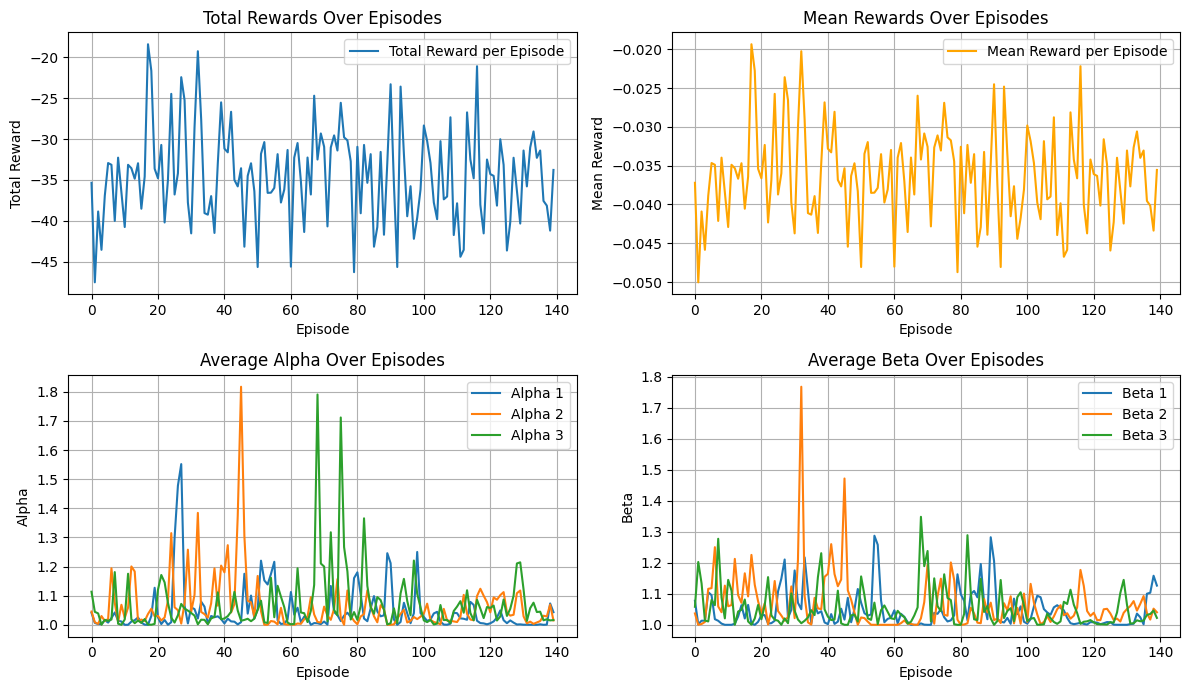

 14%|████▊                             | 140/1000 [9:11:03<56:25:04, 236.17s/it]


KeyboardInterrupt: 

In [13]:
agent = PPOAgent(
    network=actor_critic,
    lr=0.001,
    gamma=0.99,
    clip_epsilon=0.2,
    max_grad_norm=0.1,
    ppo_steps=4,
    buffer_capacity=512,
    batch_size=64
)
agent.train(env, episodes=1000)

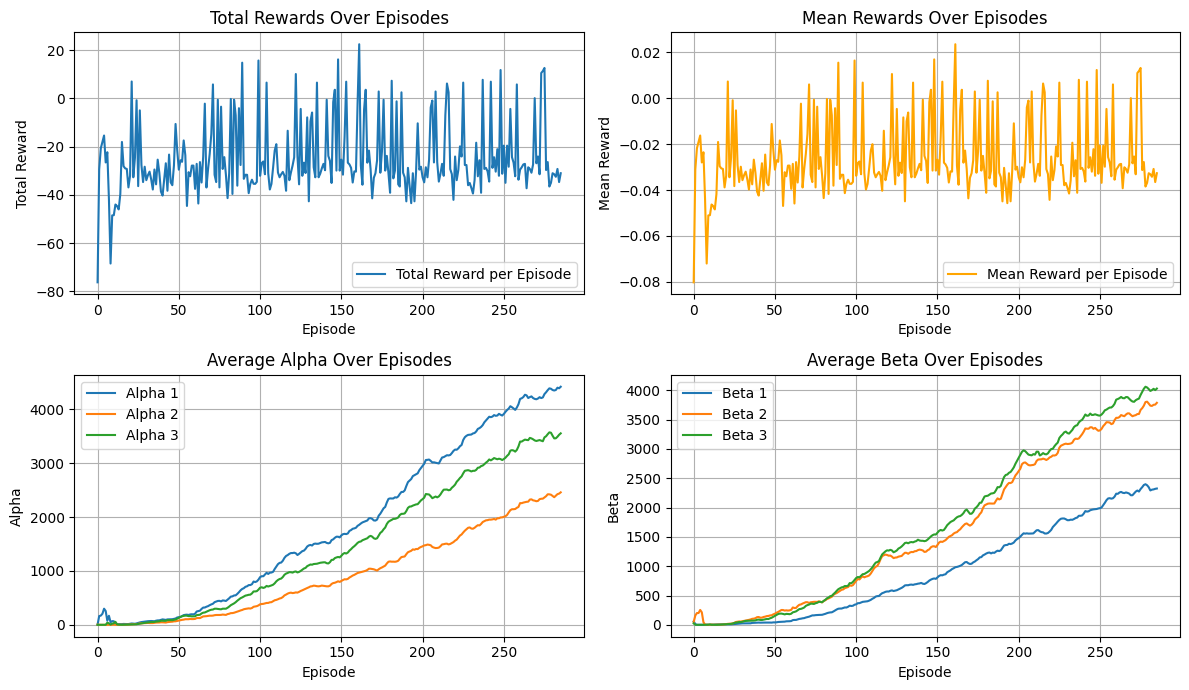

 36%|███▌      | 286/800 [6:50:10<12:17:10, 86.05s/it] 


KeyboardInterrupt: 

In [7]:
# Create and train the agent
# agent = PPOAgent(
#     actor,
#     critic,
#     lr=0.001,
#     gamma=0.99,
#     clip_epsilon=0.2,
#     max_grad_norm=1.,
#     ppo_steps=4,
#     buffer_capacity=1000,
#     batch_size=64
# )
# agent.train(env, episodes=1000)

The shape of an observation:  (4, 84, 84)


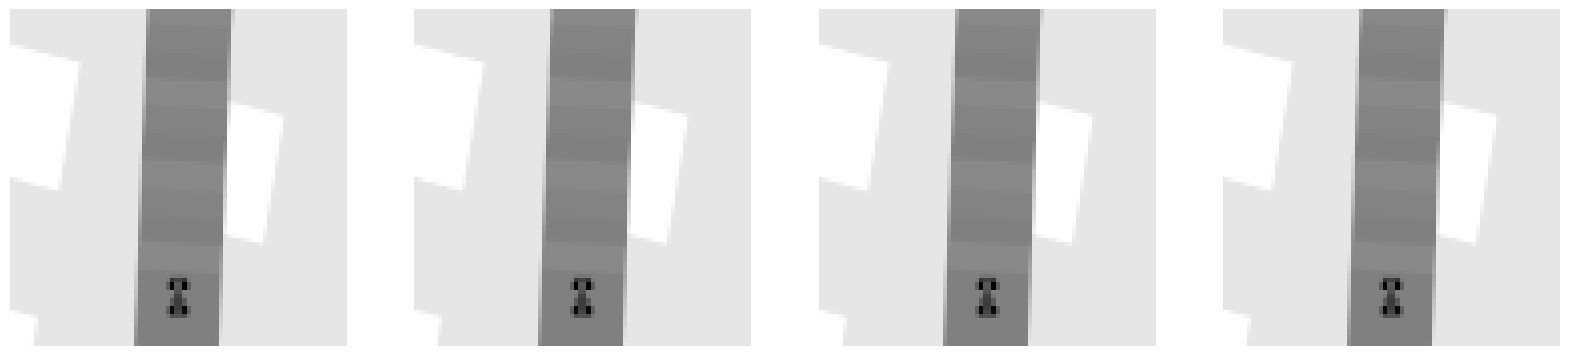

In [67]:
env = gym.make('CarRacing-v2', continuous=True)
env = CarImageEnv(env)

s, _ = env.reset()
print("The shape of an observation: ", s.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

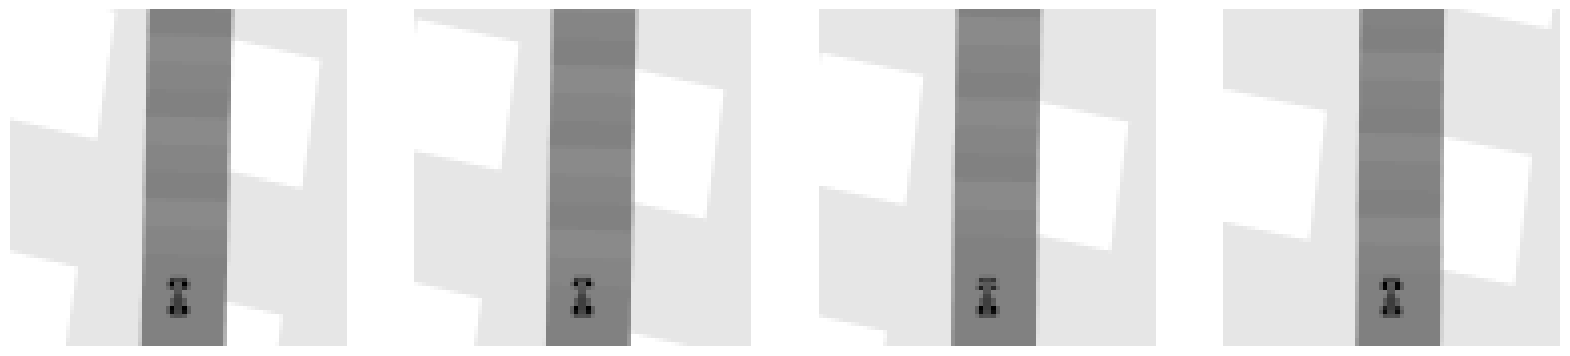

In [77]:
for i in range(4):
    s, r, terminated, truncated, info = env.step((0, 1, 0))

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()